In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy.random import shuffle


import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.autograd.profiler as tprofiler

import torch.utils.data as td

import copy
import time
import random

from PIL import Image
from pathlib import Path

plt.rcParams["savefig.bbox"] = 'tight'

In [ ]:
seed = 42

random.seed(seed)

# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
np.random.seed(seed)

In [ ]:
PATH_TO_DATASET="/content/drive/MyDrive/chest_xray/train"

def load_data(path, batch_size, input_size, norm_arr, 
              test_split, val_split,num_of_workers=0):
    
   
    transform_dict = {"train": 
                      T.Compose([
                      #T.ToPILImage(),
                      T.Resize((input_size,input_size)),
                      
                      T.RandomHorizontalFlip(),
                      #T.ColorJitter(contrast=0.5),
                      T.RandomAdjustSharpness(2),
                      T.RandomAutocontrast(),
                      
                      T.ToTensor(),
                      T.Normalize(*norm_arr)]),
                    "test_val": 
                    T.Compose([
                        # T.ToPILImage(),
                      T.Resize(size=input_size),
                      T.ToTensor(),
                      T.Normalize(*norm_arr)])
                    }
      
    data=torchvision.datasets.ImageFolder(root=PATH_TO_DATASET,transform=transform_dict["train"])
#dataset = TensorDataset(x_tensor, y_tensor)
#val_size = int(len(dataset)*0.2)
#train_size = len(dataset)- int(len(dataset)*0.2)
#train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_split=1-test_split-val_split
    train_size=int(len(data)*train_split)
    val_size=int(len(data)*val_split)
    test_size=int(len(data)*test_split)
    print("The train size, val size and test size is resp ",train_size," ",val_size," ",test_size," ",len(data))
    train,val,test=torch.utils.data.random_split(data,[train_size,val_size,test_size])
    data_loader_train = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=False, num_workers=num_of_workers, drop_last=False,pin_memory=True)
    data_loader_test = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                          shuffle=False, num_workers=num_of_workers, drop_last=False, pin_memory=True)
    data_loader_val = torch.utils.data.DataLoader(val, batch_size=batch_size,
                                          shuffle=False, num_workers=num_of_workers, drop_last=False,pin_memory=True)
    return data_loader_train, data_loader_test, data_loader_val

In [ ]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = dataiter.next()
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)), cmap='gray')

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    norm_arr = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    if model_name == "resnet":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 232
        norm_arr = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    elif model_name == "vgg":
        """ VGG16_bn
        """
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 256
        norm_arr = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
        norm_arr = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    elif model_name == "mobile_net":
        """ 
        MOBILENET_V3_LARGE
        """
        model_ft = models.mobilenet_v3_large(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[3].in_features
        model_ft.classifier[3] = nn.Linear(num_ftrs, num_classes, bias=True)
        input_size = 232
        norm_arr = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    elif model_name == "efficient_net_b1":
        """ 
        efficientnet_b1
        """
        model_ft = models.efficientnet_b1(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes, bias=True)

        input_size = 255
        norm_arr = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    elif model_name == "efficient_net_b0":
        """ 
        efficientnet_b0
        """
        model_ft = models.efficientnet_b0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes, bias=True)
        
        input_size = 256
        norm_arr = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size, norm_arr

In [ ]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "mobile_net"

# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 96

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False
# Initialize the model for this run
model_ft, input_size, norm_arr = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)

# Print the model we just instantiated
#print(model_ft)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
data_loader_train, data_loader_val, data_loader_test = load_data(PATH_TO_DATASET,
                                                                 batch_size, 
                                                                 input_size, 
                                                                 norm_arr,
                                                                 0.25,0.25,2)
data_loaders = {'train': data_loader_train,
                'val': data_loader_val}

The train size, val size and test size is resp  2928   1464   1464   5856


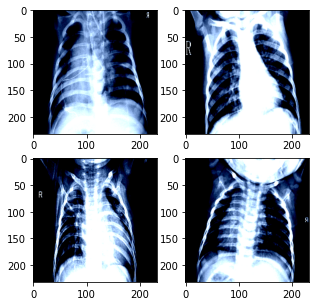

In [ ]:
plot_data_loader(data_loader_train, (2,2))


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, profiler=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    prof = None

    total_steps = len(dataloaders['train'])

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            i = 0
            for inputs, labels in dataloaders[phase]:
                i+=1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                #optimizer.zero_grad()
                for param in model.parameters():
                    param.grad = None

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        if profiler:
                            with tprofiler.profile(with_stack=True, profile_memory=True) as prof:
                                outputs, aux_outputs = model(inputs)
                        else:
                            outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        if profiler:
                              with tprofiler.profile(with_stack=True, profile_memory=True) as prof:
                                  outputs = model(inputs)
                        else:
                              outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                curr_loss = loss.item()
                running_loss += curr_loss * inputs.size(0)
                curr_acc = torch.sum(preds == labels.data)
                running_corrects += curr_acc

                if (i) % 100 == 0:
                    print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i}/{total_steps}], Loss: {curr_loss:.4f}, Accuracy: {curr_acc:.2f}%')


            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            elif phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, prof, val_acc_history, val_loss_history, train_acc_history, train_loss_history

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001)

cpu
Params to learn:
	 features.0.0.weight
	 features.0.1.weight
	 features.0.1.bias
	 features.1.block.0.0.weight
	 features.1.block.0.1.weight
	 features.1.block.0.1.bias
	 features.1.block.1.0.weight
	 features.1.block.1.1.weight
	 features.1.block.1.1.bias
	 features.2.block.0.0.weight
	 features.2.block.0.1.weight
	 features.2.block.0.1.bias
	 features.2.block.1.0.weight
	 features.2.block.1.1.weight
	 features.2.block.1.1.bias
	 features.2.block.2.0.weight
	 features.2.block.2.1.weight
	 features.2.block.2.1.bias
	 features.3.block.0.0.weight
	 features.3.block.0.1.weight
	 features.3.block.0.1.bias
	 features.3.block.1.0.weight
	 features.3.block.1.1.weight
	 features.3.block.1.1.bias
	 features.3.block.2.0.weight
	 features.3.block.2.1.weight
	 features.3.block.2.1.bias
	 features.4.block.0.0.weight
	 features.4.block.0.1.weight
	 features.4.block.0.1.bias
	 features.4.block.1.0.weight
	 features.4.block.1.1.weight
	 features.4.block.1.1.bias
	 features.4.block.2.fc1.weight
	 f

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, prof, val_acc_history, val_loss_history, train_acc_history, train_loss_history = train_model(model_ft, data_loaders, criterion, 
                             optimizer_ft, num_epochs=num_epochs, 
                             is_inception=(model_name=="inception"),
                             profiler=True)

Epoch 1/50
----------
train Loss: 0.8172 Acc: 0.6226
val Loss: 1.0878 Acc: 0.4563

Epoch 2/50
----------
train Loss: 0.6234 Acc: 0.7046
val Loss: 1.1748 Acc: 0.4563

Epoch 3/50
----------
train Loss: 0.5404 Acc: 0.7725
val Loss: 1.2305 Acc: 0.4563

Epoch 4/50
----------
train Loss: 0.4983 Acc: 0.7913
val Loss: 1.2890 Acc: 0.4563

Epoch 5/50
----------
train Loss: 0.4716 Acc: 0.8046
val Loss: 1.3044 Acc: 0.4563

Epoch 6/50
----------
train Loss: 0.4369 Acc: 0.8193
val Loss: 1.3609 Acc: 0.4563

Epoch 7/50
----------
train Loss: 0.4113 Acc: 0.8255
val Loss: 1.4093 Acc: 0.4563

Epoch 8/50
----------
train Loss: 0.3976 Acc: 0.8344
val Loss: 1.5167 Acc: 0.4563

Epoch 9/50
----------
train Loss: 0.3744 Acc: 0.8426
val Loss: 1.6898 Acc: 0.4563

Epoch 10/50
----------
train Loss: 0.3523 Acc: 0.8548
val Loss: 1.8685 Acc: 0.4563

Epoch 11/50
----------
train Loss: 0.3316 Acc: 0.8620
val Loss: 1.9557 Acc: 0.4563

Epoch 12/50
----------
train Loss: 0.3455 Acc: 0.8637
val Loss: 2.0700 Acc: 0.4563

E

In [ ]:
print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=50))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Source Location                                            
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------------------  
                                aten::cudnn_convolution        47.02%       7.273ms        54.70%       8.462ms     130.185us           0 b           0 b     535.55 Mb     521.30 Mb            65  runpy.py(85): _run_code        

In [ ]:
val_acc_history

[tensor(0.4631, device='cuda:0', dtype=torch.float64),
 tensor(0.4631, device='cuda:0', dtype=torch.float64),
 tensor(0.7391, device='cuda:0', dtype=torch.float64),
 tensor(0.7548, device='cuda:0', dtype=torch.float64),
 tensor(0.7493, device='cuda:0', dtype=torch.float64),
 tensor(0.7630, device='cuda:0', dtype=torch.float64),
 tensor(0.7398, device='cuda:0', dtype=torch.float64),
 tensor(0.7937, device='cuda:0', dtype=torch.float64),
 tensor(0.7671, device='cuda:0', dtype=torch.float64),
 tensor(0.7589, device='cuda:0', dtype=torch.float64),
 tensor(0.7398, device='cuda:0', dtype=torch.float64),
 tensor(0.7418, device='cuda:0', dtype=torch.float64),
 tensor(0.7473, device='cuda:0', dtype=torch.float64),
 tensor(0.7753, device='cuda:0', dtype=torch.float64),
 tensor(0.7240, device='cuda:0', dtype=torch.float64),
 tensor(0.7411, device='cuda:0', dtype=torch.float64),
 tensor(0.7657, device='cuda:0', dtype=torch.float64),
 tensor(0.7452, device='cuda:0', dtype=torch.float64),
 tensor(0.

In [ ]:
val_loss_history

[1.1538254042140772,
 1.9678974503376445,
 0.6993510703571507,
 0.6274286513445807,
 0.5811470966847216,
 0.6392117983005086,
 0.6282633533243274,
 0.5398119815060349,
 0.602160955061678,
 0.5670939669257304,
 0.6763359630694155,
 0.6086245325745129,
 0.7005701006435957,
 0.6227192439016749,
 0.8614154653471024,
 0.6660839778478028,
 0.7103005530404263,
 0.7742691088895328,
 0.8155909972112687,
 0.9157468657024571,
 0.8554047736965242,
 1.016943998024112,
 0.9942776590097145,
 1.0365732556483784,
 0.8616014328159269,
 1.0280185410233795,
 1.196011875496536,
 1.0627700686454773,
 0.9172601592345316,
 1.1604994408419875,
 1.026908118216718,
 1.0736275852703658,
 1.1476700169141176,
 1.1337613746768138,
 1.2636952751972637,
 1.0429020914875093,
 1.0546291553583302,
 0.9832056526277886,
 1.0936459654667339,
 1.2791821546241886,
 1.2432818803630892,
 1.3122720200507367,
 1.0979303727384473,
 1.1577149619821643,
 1.2797289989033684,
 1.1683510639628425,
 1.2706787977062288,
 1.40603968940797

In [ ]:
train_acc_history

[tensor(0.6093, device='cuda:0', dtype=torch.float64),
 tensor(0.7213, device='cuda:0', dtype=torch.float64),
 tensor(0.7493, device='cuda:0', dtype=torch.float64),
 tensor(0.7637, device='cuda:0', dtype=torch.float64),
 tensor(0.7739, device='cuda:0', dtype=torch.float64),
 tensor(0.7913, device='cuda:0', dtype=torch.float64),
 tensor(0.7917, device='cuda:0', dtype=torch.float64),
 tensor(0.8033, device='cuda:0', dtype=torch.float64),
 tensor(0.8156, device='cuda:0', dtype=torch.float64),
 tensor(0.8299, device='cuda:0', dtype=torch.float64),
 tensor(0.8391, device='cuda:0', dtype=torch.float64),
 tensor(0.8426, device='cuda:0', dtype=torch.float64),
 tensor(0.8637, device='cuda:0', dtype=torch.float64),
 tensor(0.8586, device='cuda:0', dtype=torch.float64),
 tensor(0.8849, device='cuda:0', dtype=torch.float64),
 tensor(0.8945, device='cuda:0', dtype=torch.float64),
 tensor(0.9191, device='cuda:0', dtype=torch.float64),
 tensor(0.9105, device='cuda:0', dtype=torch.float64),
 tensor(0.

In [ ]:
train_loss_history

[0.8692043521365181,
 0.6615190242157608,
 0.6074480482789336,
 0.5759108393895821,
 0.5359538192631769,
 0.5011734566727623,
 0.48426323054266757,
 0.4593202955410129,
 0.43233918703970364,
 0.40831568568456367,
 0.3736187156106605,
 0.38439169428387626,
 0.33080708443141377,
 0.3444642759248859,
 0.2924109093967031,
 0.27718636369118926,
 0.21674101848582752,
 0.22652995012334134,
 0.20941987951270868,
 0.1828970176274659,
 0.19288521235594985,
 0.15586552292597097,
 0.15026342392456335,
 0.15000671759003498,
 0.15038707852363586,
 0.14110496847844514,
 0.11929927621281049,
 0.10222955194653058,
 0.10479814922589747,
 0.10063374445575182,
 0.10733394953803937,
 0.09349438489307879,
 0.0737075295726784,
 0.09082864173000953,
 0.0619282207039536,
 0.077731005007737,
 0.07319153348350378,
 0.0698188736912657,
 0.0628565329081211,
 0.05784607086269582,
 0.04650204647408768,
 0.04901591538772231,
 0.06268239074737811,
 0.0543635429005276,
 0.042781305606247946,
 0.044693051470962704,
 0.0

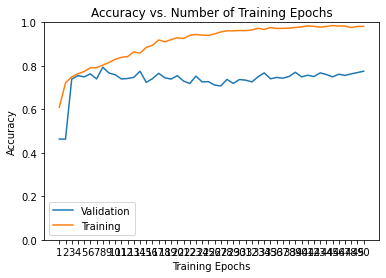

In [ ]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
vhist = []
vhist = [h.cpu().numpy() for h in val_acc_history]
thist = []
thist = [h.cpu().numpy() for h in train_acc_history]

plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
#plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),vhist,label="Validation")
plt.plot(range(1,num_epochs+1),thist,label="Training")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
vhist

[array(0.46311475),
 array(0.46311475),
 array(0.73907104),
 array(0.75478142),
 array(0.74931694),
 array(0.76297814),
 array(0.7397541),
 array(0.79371585),
 array(0.7670765),
 array(0.75887978),
 array(0.7397541),
 array(0.74180328),
 array(0.74726776),
 array(0.77527322),
 array(0.72404372),
 array(0.74112022),
 array(0.76571038),
 array(0.74521858),
 array(0.73907104),
 array(0.75478142),
 array(0.73019126),
 array(0.71857923),
 array(0.75273224),
 array(0.7260929),
 array(0.72745902),
 array(0.71174863),
 array(0.70765027),
 array(0.73770492),
 array(0.7192623),
 array(0.73702186),
 array(0.73428962),
 array(0.7260929),
 array(0.74931694),
 array(0.76775956),
 array(0.74043716),
 array(0.7465847),
 array(0.7431694),
 array(0.75136612),
 array(0.7704918),
 array(0.74931694),
 array(0.7568306),
 array(0.75068306),
 array(0.76775956),
 array(0.7602459),
 array(0.74931694),
 array(0.76161202),
 array(0.75614754),
 array(0.76297814),
 array(0.76912568),
 array(0.77527322)]

In [ ]:
thist

[array(0.60928962),
 array(0.72131148),
 array(0.74931694),
 array(0.7636612),
 array(0.7739071),
 array(0.79132514),
 array(0.79166667),
 array(0.80327869),
 array(0.81557377),
 array(0.82991803),
 array(0.83913934),
 array(0.84255464),
 array(0.86372951),
 array(0.85860656),
 array(0.88490437),
 array(0.89446721),
 array(0.91905738),
 array(0.91051913),
 array(0.92076503),
 array(0.92930328),
 array(0.92588798),
 array(0.94023224),
 array(0.9443306),
 array(0.94125683),
 array(0.94023224),
 array(0.94672131),
 array(0.95594262),
 array(0.96106557),
 array(0.96106557),
 array(0.96243169),
 array(0.96209016),
 array(0.9648224),
 array(0.9726776),
 array(0.96755464),
 array(0.9760929),
 array(0.97199454),
 array(0.97233607),
 array(0.97370219),
 array(0.97643443),
 array(0.97916667),
 array(0.98394809),
 array(0.98155738),
 array(0.97814208),
 array(0.98121585),
 array(0.98531421),
 array(0.9829235),
 array(0.9829235),
 array(0.97643443),
 array(0.98121585),
 array(0.98155738)]

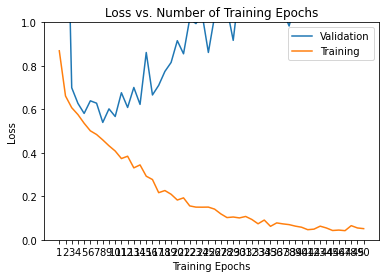

In [ ]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
vhist = []
vhist = [h for h in val_loss_history]
thist = []
thist = [h for h in train_loss_history]

plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
#plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),vhist,label="Validation")
plt.plot(range(1,num_epochs+1),thist,label="Training")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
vhist

[1.1538254042140772,
 1.9678974503376445,
 0.6993510703571507,
 0.6274286513445807,
 0.5811470966847216,
 0.6392117983005086,
 0.6282633533243274,
 0.5398119815060349,
 0.602160955061678,
 0.5670939669257304,
 0.6763359630694155,
 0.6086245325745129,
 0.7005701006435957,
 0.6227192439016749,
 0.8614154653471024,
 0.6660839778478028,
 0.7103005530404263,
 0.7742691088895328,
 0.8155909972112687,
 0.9157468657024571,
 0.8554047736965242,
 1.016943998024112,
 0.9942776590097145,
 1.0365732556483784,
 0.8616014328159269,
 1.0280185410233795,
 1.196011875496536,
 1.0627700686454773,
 0.9172601592345316,
 1.1604994408419875,
 1.026908118216718,
 1.0736275852703658,
 1.1476700169141176,
 1.1337613746768138,
 1.2636952751972637,
 1.0429020914875093,
 1.0546291553583302,
 0.9832056526277886,
 1.0936459654667339,
 1.2791821546241886,
 1.2432818803630892,
 1.3122720200507367,
 1.0979303727384473,
 1.1577149619821643,
 1.2797289989033684,
 1.1683510639628425,
 1.2706787977062288,
 1.40603968940797

In [ ]:
thist

[0.8692043521365181,
 0.6615190242157608,
 0.6074480482789336,
 0.5759108393895821,
 0.5359538192631769,
 0.5011734566727623,
 0.48426323054266757,
 0.4593202955410129,
 0.43233918703970364,
 0.40831568568456367,
 0.3736187156106605,
 0.38439169428387626,
 0.33080708443141377,
 0.3444642759248859,
 0.2924109093967031,
 0.27718636369118926,
 0.21674101848582752,
 0.22652995012334134,
 0.20941987951270868,
 0.1828970176274659,
 0.19288521235594985,
 0.15586552292597097,
 0.15026342392456335,
 0.15000671759003498,
 0.15038707852363586,
 0.14110496847844514,
 0.11929927621281049,
 0.10222955194653058,
 0.10479814922589747,
 0.10063374445575182,
 0.10733394953803937,
 0.09349438489307879,
 0.0737075295726784,
 0.09082864173000953,
 0.0619282207039536,
 0.077731005007737,
 0.07319153348350378,
 0.0698188736912657,
 0.0628565329081211,
 0.05784607086269582,
 0.04650204647408768,
 0.04901591538772231,
 0.06268239074737811,
 0.0543635429005276,
 0.042781305606247946,
 0.044693051470962704,
 0.0

In [ ]:
torch.save(model_ft.state_dict(), 'Efficientnet_b0_batch_96_epoch_50_num_workers_2_flip_auto_cont_sharp_model_weights.pth')

In [ ]:
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/AAI/Efficientnet_b0_batch_96_epoch_50_num_workers_2_flip_auto_cont_sharp_model_weights.pth')